In [110]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

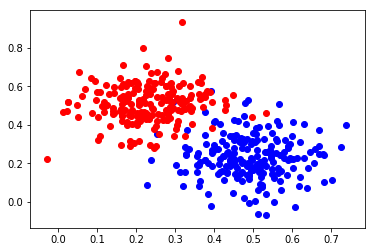

In [111]:
blue_points = 200
blue_mean = np.array([1/2, 1/4])
red_points = 200
red_mean = np.array([1/4, 1/2])
data_blue = blue_mean + np.random.normal(size=[blue_points,2], scale = 0.1) 
data_red = red_mean + np.random.normal(size = [red_points,2], scale = 0.1)

plt.scatter(data_blue[:,0], data_blue[:,1], c = 'b')
plt.scatter(data_red[:,0], data_red[:,1], c = 'r')


data_blue1 = []
data_red1 = []
for i in range(len(data_blue)):
    new_point = np.append(data_blue[i], 0)
    data_blue1.append(new_point)
for i in range(len(data_red)):
    new_point = np.append(data_red[i], 1)
    data_red1.append(new_point)

data = data_blue1 + data_red1
random.shuffle(data)
data = np.array(data)

In [112]:
input_size = 3
representation_size = 2

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 100)
        self.en_mu = nn.Linear(100, representation_size)
        self.en_std = nn.Linear(100, representation_size)
        self.de1 = nn.Linear(representation_size, 100)
        self.relu = nn.ReLU()
        self.de2 = nn.Linear(100, input_size)
        self.sigmoid = nn.Sigmoid()
            
    def encode(self, x):
        h1 = self.en1(x)
        r1 = self.relu(h1)
        mu = self.en_mu(r1)
        std = self.en_std(r1)
        return mu, std
    
    def decode(self, z):
        h2 = self.de1(z)
        r2 = self.relu(h2)
        h3 = self.de2(r2)
        output = self.sigmoid(h3)
        #output = h3
        return output
        
    def normal(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def loss(self, reconstruction, x, mu, logvar):
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5*torch.sum(1+logvar - mu.pow(2) - logvar.exp())
        KLD /= x.view(-1, input_size).data.shape[0]*input_size
        return bce
    
    def forward(self, x):
        mu, std = self.encode(x)
        z = self.normal(mu, std)
        output = self.decode(z)
        return output, mu, std

In [113]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [114]:
def train(epoch, x):
    model.train()
    
    for i in range(epoch):
        for j in range(len(x)):
            point = x[j]
            point = Variable(torch.FloatTensor(point).float(), requires_grad=True)
            target = point.clone()
            target = Variable(torch.FloatTensor(target).float(), requires_grad=False)
            optimizer.zero_grad()
            output, mu, std = model(point)
            loss =  model.loss(output, target, mu, std)
            loss.backward()
            optimizer.step()
            if j % 300 == 0:
                print("Epoch {} - loss: {}".format(i, loss.data))

In [115]:
train(0, data)

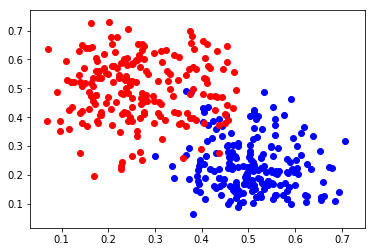

In [116]:

plt.scatter(blues[:,0], blues[:,1], c = 'b')
plt.scatter(reds[:,0], reds[:,1], c = 'r')